In [12]:
!pip install geopandas

In [15]:
import pandas as pd
import numpy as np
from sqlalchemy import engine
import folium
import geopandas as gpd
from shapely.geometry import Point


In [16]:
conn_string = r"postgresql://masterschool-analyst:pa84cc0d01e9b241460abdf838bb34f5932c9473dca571b56fcb13dd3023a62e0@ec2-52-4-84-108.compute-1.amazonaws.com:5432/da541q56oobji4"
connection = engine.create_engine(conn_string)

In [17]:
cte_query = """
  SELECT 
    order_id, 
    partner_id AS operator_id, 
    partner_name AS operator_name, 
    status, 
    m.source, 
    fullname, 
    email AS customer_email, 
    company_name, 
    confirmation_id, 
    space_id, 
    space_name, 
    created_at, 
    promotion_code, 
    total_price AS final_price, 
    --not usd,  sub_total + tax_amount, sub_total=order_line_item_total_price
    ABS(discounted_amount) AS discounted_amount, 
    --not usd
    total_price_in_usd AS final_price_usd, 
    --amount transacted through Flexspace
    ABS(ROUND(
      discounted_amount * to_usd_rate, 2
    )) AS discounted_amount_usd, 
    ROUND(
      (
        total_price_in_usd + ABS(discounted_amount * to_usd_rate)
      ), 
      2
    ) AS original_price_usd, 
    processing_fee_in_usd, 
    to_usd_rate, 
    location_id, 
    location_name_en, 
    location_time_zone, 
    country, 
    m.state, 
    city, 
    order_line_item_id, 
    orderable_type, 
    orderable_id, 
    order_line_item_details, 
    access_id, 
    booking_product_type, 
    product_type_id, 
    add_on_days_to_expire, 
    capacity, 
    booking_id, 
    start_date, 
    end_date, 
    date, 
    quantity, 
    last_refresh 
  FROM 
    mat_orders AS m 
  WHERE 
    status = 'paid' 
    AND email NOT IN (
      SELECT 
        email 
      FROM 
        mat_orders 
      WHERE 
        1 = 1 
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%' 
          OR email ILIKE '%%test%%' 
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    ) 
    AND m.source IN ('WL', 'FM')
    AND created_at < '2023-07-01'
;

"""

filtered_df = pd.read_sql(cte_query, con=conn_string)

## Geographical spread

In [18]:
lonlat_query = """select partner_name || ' - ' || space_name as space_name
    , coalesce(mat_orders.city, locations.city) as city
    , coalesce(mat_orders.country, locations.country) as country
    , coalesce(mat_orders.state, locations.state) as state
    , longitude
    , latitude
    , count(order_id)
from mat_orders
left join locations
    on mat_orders.location_id = locations.id
where 1=1
and source in ('WL', 'FM')
AND status ='paid'
AND mat_orders.created_at < '2023-07-01'
 AND email NOT IN (
      SELECT
        email
      FROM
        mat_orders
      WHERE
        1 = 1
        AND (
          company_name ILIKE '%%test%%'
          OR fullname ILIKE '%%test%%'
          OR email ILIKE '%%test%%'
          OR promotion_code ILIKE '%%test%%'
          OR partner_name ILIKE '%%test%%'
        )
    )
group by 1,2,3,4,5,6;

"""

locations_ = pd.read_sql(lonlat_query, con=conn_string)

In [19]:
locations_ = locations_.dropna(thresh=5).copy()
gdf_ = gpd.GeoDataFrame(locations_, geometry=gpd.points_from_xy(locations_['longitude'], locations_['latitude']))


In [20]:
def create_maps(gdf, is_global=True):
    
    def map_creator(temp_df, city):    
        # Add points to the map
        for idx, row in temp.iterrows():
            popup_text = str(row['count'])

            folium.CircleMarker(location=(row['latitude'], row['longitude']),
                                radius=row['count']/10, # change this value to adjust the size of the circle markers
                                color="blue", 
                                popup=folium.Popup(popup_text), 
                                fill=True).add_to(m)

            m.save(f"{city.title()}.html")
        
    if is_global:
        temp = gdf[['latitude', 'longitude', 'city','count']].copy()
        temp = temp.groupby(['latitude','longitude'], as_index=False).sum().copy()
        m = folium.Map(location=[30.261042, -73.993123], zoom_start=5)
        map_creator(temp, "Global")
    else:
        for city in gdf['city'].unique():
            temp = gdf[gdf['city']==city][['latitude', 'longitude', 'city','count']].copy()
            temp = temp.groupby(['latitude','longitude'], as_index=False).sum().copy()
            m = folium.Map(location=[temp['latitude'].mean(), temp['longitude'].mean()], zoom_start=13)

            map_creator(temp, city)

In [450]:
create_maps(gdf_)
create_maps(gdf_, False)

<AxesSubplot:title={'center':'Mean final price per operator distribution'}>

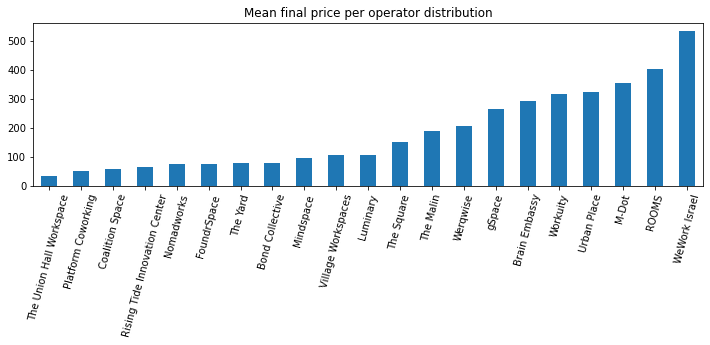

In [21]:
filtered_df.groupby('operator_name').mean()['final_price'].sort_values().plot(kind="bar", xlabel="", 
                                                                              rot=75,
                                                                              figsize=(12,3),
                                                                              title="Mean final price per operator distribution")


In [22]:
filtered_df.groupby('operator_name').sum()['final_price'].sort_values()


operator_name
The Union Hall Workspace             395.00
Coalition Space                      455.00
The Square                           760.00
Platform Coworking                   815.00
Workuity                             950.00
Rising Tide Innovation Center       1847.50
gSpace                              1850.00
Village Workspaces                  7271.60
FoundrSpace                        10972.50
Bond Collective                    30043.75
M-Dot                              35695.53
Nomadworks                         69556.50
Luminary                           84839.75
ROOMS                             105019.20
Werqwise                          115175.50
Brain Embassy                     176435.66
Urban Place                       201909.38
The Malin                         256210.25
The Yard                          269103.00
Mindspace                         862619.47
WeWork Israel                    2279715.41
Name: final_price, dtype: float64

In [23]:
# Extracting just the date from created_at as date
filtered_df['date'] = filtered_df['created_at'].dt.date

filtered_df['date'].count()

22696

In [24]:
filtered_df['date'].describe()

count          22696
unique           821
top       2023-06-21
freq             100
Name: date, dtype: object

In [25]:
# Number of unique operators
filtered_df['operator_id'].nunique()

21

In [26]:
fdf = filtered_df

# Exploring features to measure success

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
# Convert 'date' to a time stamp
fdf['date'] = pd.to_datetime(fdf['date'])
monetary_for_preperation = fdf.groupby(['operator_id', 'customer_email','date'], as_index=False)['final_price'].sum()
interim_fdf = fdf.sort_values(['operator_id', 'customer_email','created_at']).drop_duplicates(['operator_id', 'customer_email','date'])
interim_fdf = interim_fdf.drop('final_price', axis=1)

In [29]:
fdf = interim_fdf.merge(monetary_for_preperation).copy()


In [30]:
country_totals = pd.DataFrame(fdf.groupby('country', as_index = False)['final_price_usd'].sum())

In [31]:
country_totals = country_totals.sort_values(by='final_price_usd', ascending=False).reset_index(drop=True)

In [32]:
country_totals

,country,final_price_usd
0,US,868369.54
1,IL,741107.85
2,DE,340928.25
3,GB,125481.03
4,NL,63256.89
5,PL,36958.07
6,RO,24499.01


Text(0.5, 1.0, 'Country Monetary Value')

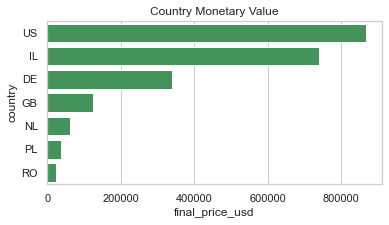

In [33]:
plt.figure(figsize = (6, 3))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Greens_d", 1)

sns.barplot(y = country_totals['country'], x = country_totals['final_price_usd'], palette= pal)

plt.title('Country Monetary Value')

The US has generated the most followed closely by Israel

In [34]:
country_operator = pd.DataFrame(fdf.groupby('country', as_index = False)['operator_name'].nunique()).sort_values(by='operator_name', ascending=False).reset_index(drop=True)
                                                                                                               

In [35]:
country_operator

,country,operator_name
0,US,16
1,IL,6
2,PL,2
3,DE,1
4,GB,1
5,NL,1
6,RO,1


Text(0.5, 1.0, 'Operators in each Country')

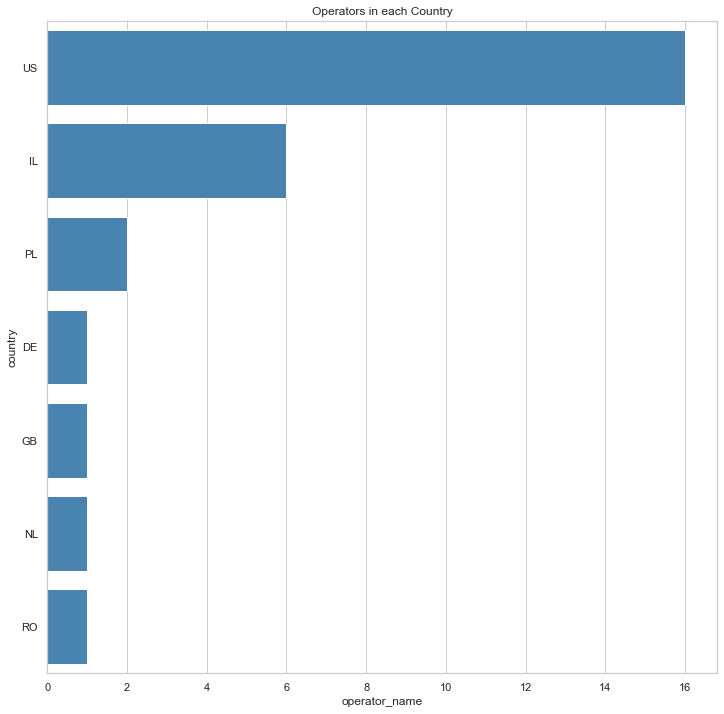

In [36]:
plt.figure(figsize = (12, 12))

sns.set(style="whitegrid", color_codes=True)

pal = sns.color_palette("Blues_d", 1)

sns.barplot(y = country_operator['country'], x = country_operator['operator_name'], palette= pal)

plt.title('Operators in each Country')

It seems a variety of operaters in a country positively correlates with higher revenues. 

Mindspace has a footprint in every country, the most being in Germany.

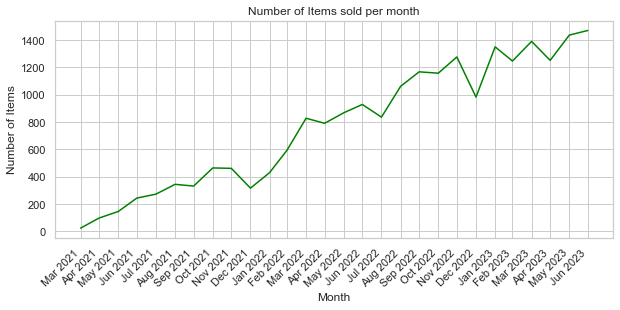

In [37]:
df_group = pd.DataFrame(fdf.resample('M', on='date')['order_id'].count())
df_group.columns = ['Number_of_items_sold']
    
plt.figure(figsize=(10, 4))
sns.lineplot(x=df_group.index, y=df_group['Number_of_items_sold'], color = 'Green')

# Set the chart title and axis labels
plt.title('Number of Items sold per month')
plt.xlabel('Month')
plt.ylabel('Number of Items')

plt.xticks(df_group.index, df_group.index.strftime('%b %Y'), rotation=45, ha='right')
plt.show()

The number of sold products has been rising steadily with the expectation of dips withiin December as seen in 2021 and 2022.

In [38]:
operator_group = pd.DataFrame(fdf.groupby(['operator_key', 'order_id', 'date'], as_index = False )['final_price_usd'].sum())


KeyError: 'operator_key'

In [ ]:
operator_group.head()

In [ ]:
operator_group.shape

# RFM Analysis

An rfm analysis is a segmentation and behavioral targeting technique that will rank and categorize operators according to their recency, frequency, and monetary value of their transactions.

- The recency metric measures the time elapsed since an operator's transaction
- The frequency evaluates how frequently customers cunducted transactions with the operators
- The monetary values quantifies the amount of money spent

### RFM Function


In [40]:
fdf['operator_key'] = fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']
fdf['operator_full_name'] = fdf['operator_name']+"-"+fdf['country']+"-"+np.where(fdf['state'].isin([None]),"", fdf['state']+"-")+fdf['city']

pivot_table = fdf.groupby(['operator_name', 'operator_key']).size().unstack(fill_value=0)

# pivot_table.astype(bool).sum(axis=1).sort_values(ascending=False)

In [116]:
def create_extended_rfm_by(fdf_, key="operator_name"):

    # this is a bogus filter - you can change that however you like
    fdf_filtered = fdf_[fdf_['date'] < pd.to_datetime('2023-07-01')].copy()
    
    #recency and lifetime
    df_recency = fdf_filtered.groupby(key)['date'].agg(["max", "min"]).reset_index()
    df_recency.columns = ['operator', 'last_order', "first_order"]
    
    df_recency['recency'] = (pd.Timestamp.now().normalize() - df_recency['last_order']).dt.days
    df_recency['lifetime'] = (df_recency['last_order'] - df_recency['first_order']).dt.days+1
    
    #monetary and frequency 
    df_monetary_freq = fdf_filtered.groupby(key)['final_price_usd'].agg(['count', sum]).copy().reset_index()
    df_monetary_freq.columns = ['operator', 'frequency', "monetary"]

    
    # Count number of orders for each customer and partner
    df_orders = fdf_filtered.groupby([key, 'customer_email']).size().reset_index(name='orders')
    # Calculate whether the customer has returned (1 if 'orders' > 1, 0 otherwise)
    df_orders['returned'] = (df_orders['orders'] > 1).astype(int)

    # # Now group by partner_name and calculate total customers and returning customers
    df_final = df_orders.groupby(key).agg(total_customers=('customer_email', 'count'), returning_customers=('returned', 'sum')).reset_index()
    df_final['return_rate'] = df_final['returning_customers'] / df_final['total_customers']
#     df_final = df_final.drop(['returning_customers', 'total_customers'], axis=1).copy()
    df_final.columns = ['operator', "total_customers", "returning_customers", "return_rate"]
    
    df = df_recency.merge(df_monetary_freq).merge(df_final).copy()
    df = df.drop(['last_order','first_order','returning_customers'], axis=1)
    df['intensity'] = df['frequency']/df['lifetime']
    return df


In [117]:
rfm_by_operator_name = create_extended_rfm_by(fdf)
rfm_by_full_name = create_extended_rfm_by(fdf, key="operator_full_name")

In [118]:
rfm_by_full_name

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
0,Bond Collective-US-CA-Los Angeles,22,85,21,1362.50,20,0.050000,0.247059
1,Bond Collective-US-DC-Washington,93,9,5,125.00,3,0.666667,0.555556
2,Bond Collective-US-IL-Chicago,19,91,46,5650.00,43,0.069767,0.505495
3,Bond Collective-US-NY-Brooklyn,19,89,173,9650.00,136,0.198529,1.943820
4,Bond Collective-US-NY-New York,20,80,59,4143.75,49,0.142857,0.737500
...,...,...,...,...,...,...,...,...
57,Werqwise-US-CA-San Francisco,21,595,340,62219.75,267,0.168539,0.571429
58,Werqwise-US-CA-San Mateo,19,541,185,36028.50,150,0.133333,0.341959
59,Workuity-US-AZ-Chandler,22,2,3,950.00,2,0.500000,1.500000
60,gSpace-US-CT-Fairfield,50,43,3,750.00,2,0.500000,0.069767


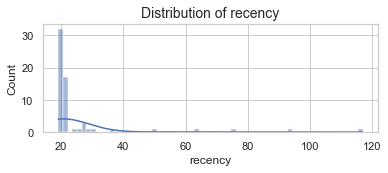

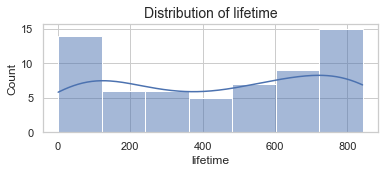

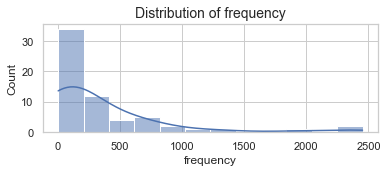

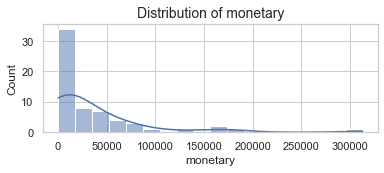

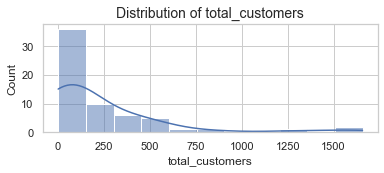

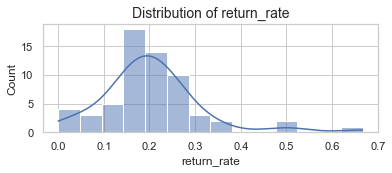

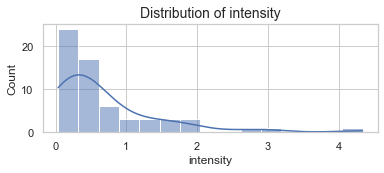

In [119]:
# Create separate plots for each numeric column
for col in rfm_by_full_name.select_dtypes(include='number').columns:
    plt.figure(figsize=(6, 2))
    sns.histplot(data=rfm_by_full_name, x=col, kde=True)
    plt.title(f'Distribution of {col}', fontsize=14)
    plt.show()


In [120]:
rfm_by_full_name.sort_values('return_rate', ascending=False)

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
1,Bond Collective-US-DC-Washington,93,9,5,125.00,3,0.666667,0.555556
60,gSpace-US-CT-Fairfield,50,43,3,750.00,2,0.500000,0.069767
59,Workuity-US-AZ-Chandler,22,2,3,950.00,2,0.500000,1.500000
24,Mindspace-IL-Yakum,20,586,80,10959.77,33,0.363636,0.136519
18,Mindspace-GB-London,19,820,1157,125481.03,531,0.333333,1.410976
...,...,...,...,...,...,...,...,...
0,Bond Collective-US-CA-Los Angeles,22,85,21,1362.50,20,0.050000,0.247059
5,Bond Collective-US-PA-Philadelphia,19,80,23,1900.00,22,0.045455,0.287500
35,ROOMS-IL-Modi'in,22,300,27,2434.82,26,0.038462,0.090000
20,Mindspace-IL-Kiryat Ono,22,21,5,402.39,5,0.000000,0.238095


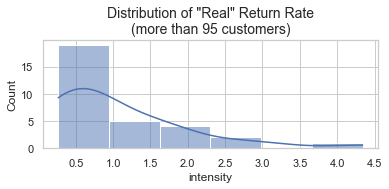

In [121]:
more_than_median =rfm_by_full_name[rfm_by_full_name['total_customers']>rfm_by_full_name['total_customers'].median()].copy()
plt.figure(figsize=(6, 2))
sns.histplot(data=more_than_median, x=col, kde=True)
plt.title(f'Distribution of "Real" Return Rate\n(more than 95 customers)', fontsize=14)
plt.show()



In [122]:
rfm_by_full_name['frequency'].median()

142.0

In [123]:
rfm_by_full_name[rfm_by_full_name['frequency']==2452]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
14,Mindspace-DE-Berlin,19,831,2452,173148.61,1520,0.250658,2.950662


## Segmentation

In [124]:
number_of_days_for_recency = 45
new_operators_days_thresh = 90

In [125]:
rfm_by_full_name.describe()

,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
count,62.000000,62.000000,62.000000,62.00000,62.000000,62.000000,62.000000
mean,25.983871,446.338710,350.548387,35493.55871,234.564516,0.204469,0.700075
std,17.701988,297.078669,524.059616,55098.78111,344.225032,0.111132,0.797688
min,19.000000,1.000000,1.000000,125.00000,1.000000,0.000000,0.036232
25%,19.000000,140.250000,34.500000,3759.32250,25.250000,0.154600,0.237086
50%,20.000000,488.500000,142.000000,11180.08000,94.500000,0.198697,0.381385
75%,22.000000,706.250000,453.750000,39026.84750,327.750000,0.249282,0.843671
max,117.000000,842.000000,2452.000000,312877.81000,1658.000000,0.666667,4.339552


In [126]:
churned_operators = rfm_by_full_name[rfm_by_full_name['recency']>number_of_days_for_recency].copy()
working_operators = rfm_by_full_name[rfm_by_full_name['recency']<=number_of_days_for_recency].copy()
new_operators = working_operators[working_operators['lifetime']<=new_operators_days_thresh].copy()
experienced_operators= working_operators[working_operators['lifetime']>new_operators_days_thresh].copy()

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'lifetime-monetary spread'}, xlabel='monetary', ylabel='lifetime'>

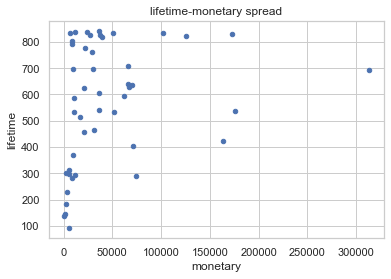

In [129]:
experienced_operators[['lifetime', 'monetary']].plot(kind='scatter', x='monetary', y='lifetime', title = "lifetime-monetary spread")

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:title={'center':'frequency-monetary spread'}, xlabel='frequency', ylabel='monetary'>

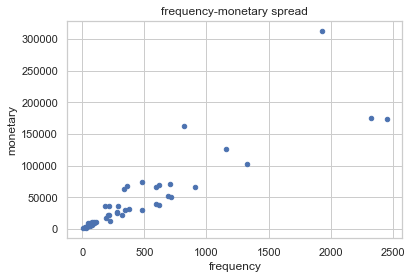

In [135]:
experienced_operators[['monetary', 'frequency']].plot(kind='scatter', x='frequency', y='monetary', title = "frequency-monetary spread")

In [137]:
experienced_operators[experienced_operators['monetary']>100000].copy()

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate,intensity
14,Mindspace-DE-Berlin,19,831,2452,173148.61,1520,0.250658,2.950662
17,Mindspace-DE-Munich,19,835,1329,101719.89,854,0.250585,1.591617
18,Mindspace-GB-London,19,820,1157,125481.03,531,0.333333,1.410976
41,The Malin-US-NY-New York,19,422,823,163029.25,520,0.230769,1.950237
46,The Yard-US-NY-New York,19,536,2326,175776.50,1658,0.168275,4.339552
56,WeWork Israel-IL-Tel Aviv,20,694,1925,312877.81,1266,0.214060,2.773775


In [56]:
working_operators[working_operators['lifetime']>365]
working_operators[working_operators['lifetime']<365]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate
0,Bond Collective-US-CA-Los Angeles,22,85,21,1362.50,20,0.050000
2,Bond Collective-US-IL-Chicago,19,91,46,5650.00,43,0.069767
3,Bond Collective-US-NY-Brooklyn,19,89,173,9650.00,136,0.198529
4,Bond Collective-US-NY-New York,20,80,59,4143.75,49,0.142857
5,Bond Collective-US-PA-Philadelphia,19,80,23,1900.00,22,0.045455
6,Bond Collective-US-TX-Austin,20,87,34,4662.50,31,0.096774
10,FoundrSpace-US-CA-Pasadena,19,312,62,5235.00,43,0.209302
11,FoundrSpace-US-CA-Rancho Cucamonga,26,297,83,5587.50,62,0.145161
20,Mindspace-IL-Kiryat Ono,22,21,5,402.39,5,0.000000
33,Platform Coworking-US-IL-Chicago,19,31,16,815.00,13,0.153846


In [575]:
rfm_by_full_name[rfm_by_full_name['frequency']<5]

,operator,recency,lifetime,frequency,monetary,total_customers,return_rate
59,Workuity-US-AZ-Chandler,22,2,3,950.0,2,0.5
60,gSpace-US-CT-Fairfield,50,43,3,750.0,2,0.5
61,gSpace-US-CT-Greenwich,27,1,1,500.0,1,0.0


In [522]:
df_final

,operator_name,total_customers,returning_customers,return_rate
0,Bond Collective,299,55,0.183946
1,Brain Embassy,419,102,0.243437
2,Coalition Space,7,1,0.142857
3,FoundrSpace,104,19,0.182692
4,Luminary,437,120,0.274600
5,M-Dot,63,11,0.174603
6,Mindspace,5554,1423,0.256212
7,Nomadworks,666,119,0.178679
8,Platform Coworking,13,2,0.153846
9,ROOMS,169,35,0.207101


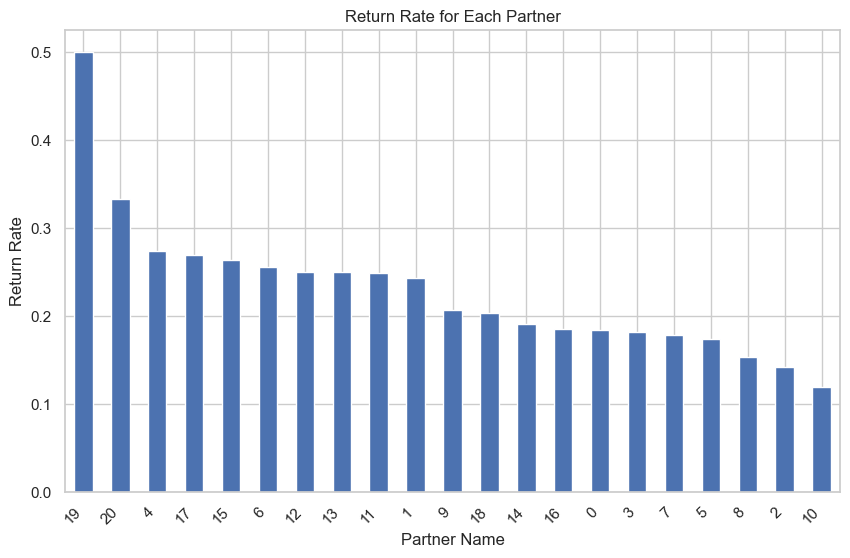

In [523]:
df_final_sorted = df_final.sort_values('return_rate', ascending=False)

df_final_sorted['return_rate'].plot(kind='bar', figsize=(10,6))
plt.title('Return Rate for Each Partner')
plt.ylabel('Return Rate')
plt.xlabel('Partner Name')
plt.xticks(rotation=45, ha='right')  # This rotates x-axis labels for better visibility
plt.show()



In [524]:
df_final.describe()

,total_customers,returning_customers,return_rate
count,21.000000,21.000000,21.000000
mean,678.047619,161.857143,0.229225
std,1317.664201,332.555302,0.080782
min,2.000000,1.000000,0.120000
25%,13.000000,2.000000,0.182692
50%,169.000000,35.000000,0.207101
75%,437.000000,119.000000,0.256212
max,5554.000000,1423.000000,0.500000


- 25% of the operators have a return_rate of 0.185185 or lower, 50% have a return_rate of 0.219780 or lower, and 75% have a return_rate of 0.256203 or lower.

- the average number of total_customers is about 699 and the average return_rate is about 0.22.

- The median (50%) is less than the mean for total_customers and returning_customers, which indicates that these distributions are skewed to the right. That means there are a few operators with a very large number of customers, which pulls the mean up.

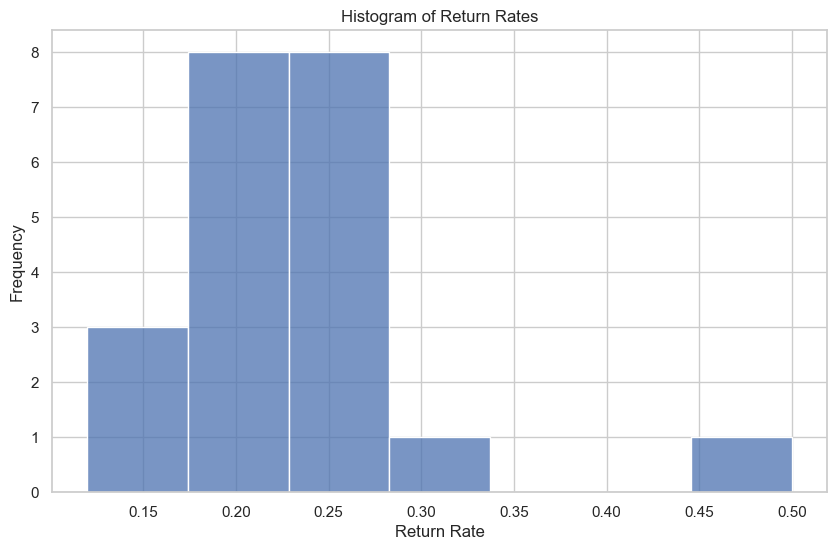

In [525]:
plt.figure(figsize=(10,6))
sns.histplot(df_final['return_rate'], bins=7, kde=False)
plt.title('Histogram of Return Rates')
plt.xlabel('Return Rate')
plt.ylabel('Frequency')
plt.show()


In [528]:
df_final.drop('total_customers', axis = 1, inplace = True)

In [529]:
df_final.drop('returning_customers', axis = 1, inplace = True)

In [530]:
df_final.columns = ['operator', 'return_rate']

In [531]:
rfm = rfm.merge(df_final, on='operator')

In [532]:
rfm.index = rfm['operator']

rfm.drop('operator', axis = 1, inplace = True)

rfm

,recency,frequency,monetary,return_rate
operator,,,,
Bond Collective,18,377,30043.75,0.183946
Brain Embassy,18,605,42261.96,0.243437
Coalition Space,75,8,455.00,0.142857
FoundrSpace,18,146,10972.50,0.182692
Luminary,18,785,85116.75,0.274600
M-Dot,23,101,10093.71,0.174603
Mindspace,18,9131,734809.33,0.256212
Nomadworks,19,932,69765.50,0.178679
Platform Coworking,18,16,815.00,0.153846


### Operator Life Time in Days 

In [534]:
#fdf['date'] = pd.to_datetime(fdf['date'])


partner_lifetimes = fdf.groupby('operator_name')['date'].agg(['min', 'max'])
partner_lifetimes['lifetime'] = (partner_lifetimes['max'] - partner_lifetimes['min']).dt.days

# Add 1 day to the 'lifetime' column
partner_lifetimes['lifetime'] = partner_lifetimes['lifetime'] + 1

In [535]:
partner_lifetimes.drop('min', axis = 1, inplace = True)

In [536]:
partner_lifetimes.drop('max', axis = 1, inplace = True)

In [537]:
partner_lifetimes

,lifetime
operator_name,
Bond Collective,91
Brain Embassy,698
Coalition Space,128
FoundrSpace,312
Luminary,403
M-Dot,368
Mindspace,843
Nomadworks,709
Platform Coworking,31


In [538]:
partner_lifetimes = partner_lifetimes.rename_axis('operator')


In [539]:
rfm = rfm.merge(partner_lifetimes, on='operator')

In [540]:
rfm.describe()

,recency,frequency,monetary,return_rate,lifetime
count,21.000000,21.000000,21.000000,21.000000,21.000000
mean,27.380952,1080.761905,113664.390952,0.229225,340.904762
std,23.768627,2158.777128,209369.418923,0.080782,261.346112
min,18.000000,3.000000,395.000000,0.120000,2.000000
25%,18.000000,16.000000,1847.500000,0.182692,128.000000
50%,19.000000,261.000000,29145.760000,0.207101,312.000000
75%,23.000000,785.000000,85116.750000,0.256212,536.000000
max,116.000000,9131.000000,734809.330000,0.500000,843.000000


# Full RFM + Features Analysis

In [541]:
quantiles = rfm.quantile(q=[0.25,0.5,0.75])
quantiles

,recency,frequency,monetary,return_rate,lifetime
0.25,18.0,16.0,1847.50,0.182692,128.0
0.50,19.0,261.0,29145.76,0.207101,312.0
0.75,23.0,785.0,85116.75,0.256212,536.0


In [542]:
quantiles.to_dict()

{'recency': {0.25: 18.0, 0.5: 19.0, 0.75: 23.0},
 'frequency': {0.25: 16.0, 0.5: 261.0, 0.75: 785.0},
 'monetary': {0.25: 1847.5, 0.5: 29145.76, 0.75: 85116.75},
 'return_rate': {0.25: 0.18269230769230768,
  0.5: 0.20710059171597633,
  0.75: 0.25621173928700036},
 'lifetime': {0.25: 128.0, 0.5: 312.0, 0.75: 536.0}}

In [543]:
# Arguments (x = value, p = recency, monetary, frequency, return_rate, lifetime, d = quartiles dict)
def RScore(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
# Arguments (x = value, p = recency, monetary, frequency, return_rate, lifetime, k = quartiles dict)
def FMScore(x,p,d):
    if x <= d[p][0.25]:
        return 1
    elif x <= d[p][0.50]:
        return 2
    elif x <= d[p][0.75]: 
        return 3
    else:
        return 4

In [544]:
#create rfm segmentation table
rfm_segmentation = rfm
rfm_segmentation['r_quartile'] = rfm_segmentation['recency'].apply(RScore, args=('recency',quantiles,))
rfm_segmentation['f_quartile'] = rfm_segmentation['frequency'].apply(FMScore, args=('frequency',quantiles,))
rfm_segmentation['m_quartile'] = rfm_segmentation['monetary'].apply(FMScore, args=('monetary',quantiles,))
rfm_segmentation['return_quartile'] = rfm_segmentation['return_rate'].apply(FMScore, args=('return_rate',quantiles,))
rfm_segmentation['lifetime_quartile'] = rfm_segmentation['lifetime'].apply(FMScore, args=('lifetime',quantiles,))


In [545]:
rfm_segmentation

,recency,frequency,monetary,return_rate,lifetime,r_quartile,f_quartile,m_quartile,return_quartile,lifetime_quartile
operator,,,,,,,,,,
Bond Collective,18,377,30043.75,0.183946,91,4,3,3,2,1
Brain Embassy,18,605,42261.96,0.243437,698,4,3,3,3,4
Coalition Space,75,8,455.00,0.142857,128,1,1,1,1,1
FoundrSpace,18,146,10972.50,0.182692,312,4,2,2,1,2
Luminary,18,785,85116.75,0.274600,403,4,3,3,4,3
M-Dot,23,101,10093.71,0.174603,368,2,2,2,1,3
Mindspace,18,9131,734809.33,0.256212,843,4,4,4,3,4
Nomadworks,19,932,69765.50,0.178679,709,3,4,3,1,4
Platform Coworking,18,16,815.00,0.153846,31,4,1,1,1,1


In [546]:
rfm_segmentation['RFMScore'] = rfm_segmentation.r_quartile.map(str) \
                            + rfm_segmentation.f_quartile.map(str) \
                            + rfm_segmentation.m_quartile.map(str) \
                            + rfm_segmentation.return_quartile.map(str) \
                            + rfm_segmentation.lifetime_quartile.map(str)


In [547]:
rfm_segmentation.sort_values('RFMScore', ascending=False)

,recency,frequency,monetary,return_rate,lifetime,r_quartile,f_quartile,m_quartile,return_quartile,lifetime_quartile,RFMScore
operator,,,,,,,,,,,
Mindspace,18,9131,734809.33,0.256212,843,4,4,4,3,4,44434
The Malin,18,1365,256210.25,0.249102,422,4,4,4,3,3,44433
The Yard,18,3403,269223.00,0.191410,536,4,4,4,2,3,44423
Werqwise,18,560,116719.50,0.203883,597,4,3,4,2,4,43424
Luminary,18,785,85116.75,0.274600,403,4,3,3,4,3,43343
Brain Embassy,18,605,42261.96,0.243437,698,4,3,3,3,4,43334
Bond Collective,18,377,30043.75,0.183946,91,4,3,3,2,1,43321
FoundrSpace,18,146,10972.50,0.182692,312,4,2,2,1,2,42212
Platform Coworking,18,16,815.00,0.153846,31,4,1,1,1,1,41111


In [548]:
rfm_segmentation_reset.columns


Index(['partner', 'recency', 'frequency', 'monetary', 'return_rate',
       'lifetime', 'r_quartile', 'f_quartile', 'm_quartile', 'return_quartile',
       'lifetime_quartile', 'RFMScore'],
      dtype='object')

In [549]:
rfm_segmentation_reset = rfm_segmentation_reset.rename(columns={'Unnamed: 0': 'operator_name'})


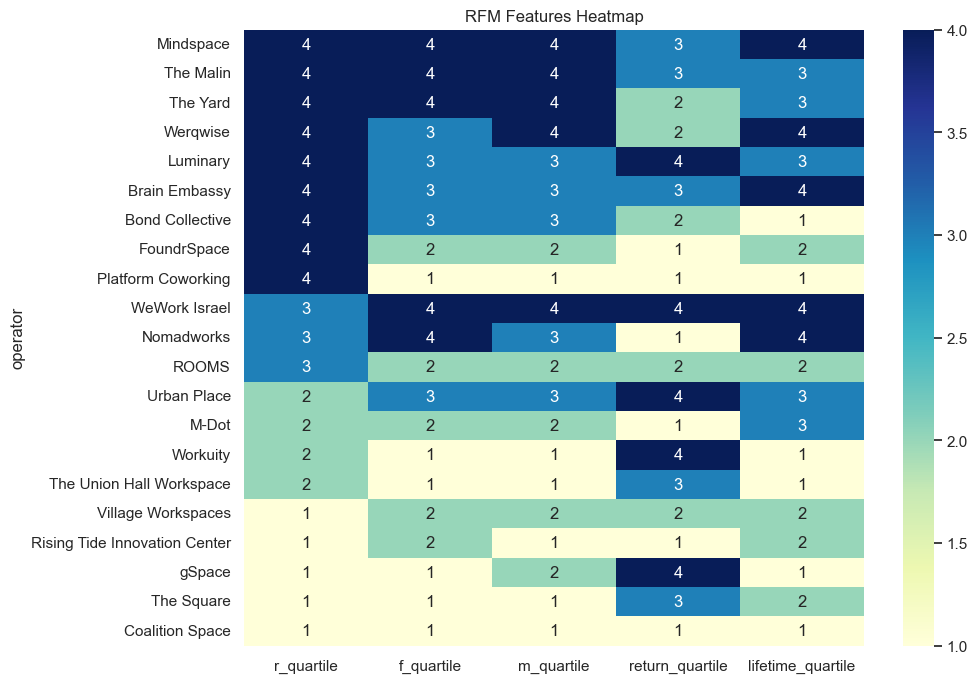

In [550]:
heatmap_data = rfm_segmentation[['r_quartile', 'f_quartile', 'm_quartile', 'return_quartile', 'lifetime_quartile']].sort_values(['r_quartile', 'f_quartile', 'm_quartile', 'return_quartile', 'lifetime_quartile'], ascending=False)
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, annot=True, cmap='YlGnBu')
plt.title('RFM Features Heatmap')
plt.show()


- The most successful operator is the one with the lowest recency, highest frequency and monetary value, highest return rate, longest lifetime


-  'Mindspace' is an extremely successful operator. They have recently transacted (recency of 18 days), have the highest frequency of transactions (9131), and have the highest total transaction value (734809.33). Their return rate (0.256212) is high, and they have a long-standing relationship with us (lifetime of 843 days). Moreover, they have high quartile scores, which means they rank near the top among all operators in recency, frequency, and monetary value. What makes them successful could be their regular and high-frequency transactions, leading to high monetary value. Their high return rate suggests successful transactions, and their long-term engagement implies a stable and strong relationship with us.


- WeWork Israel is a highly successful operator. They frequently transact with us (4256) and bring significant monetary value to our business (661162.90). Their return rate is high (0.269231), suggesting successfull returning customers. They have a longstanding relationship with us (694 days), which underscores their reliability. Given their performance, it's clear that WeWork Israel contributes significantly to our business. Their operations and successful strategies could potentially serve as a benchmark for other operators.


- gSpace is a relatively new operator (66 days) with us, doesn't transact as frequently (7) or with as high values (1850.00) as other operators, but when they do transact, they have a high return rate (0.333333). Their overall performance score is relatively low due to lower frequency and monetary value, but the high return rate suggests potential for future success as they continue to transact with us. This operator could benefit from strategies to increase their transaction frequency and monetary value while maintaining their high return rate.

